# Volume 3: ARMA Models
    <Name>
    <Class>
    <Date>

In [1]:
# Import imports
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats.distributions import norm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.base.datetools import dates_from_str
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm
from statsmodels.tsa.stattools import arma_order_select_ic as order_select
import pandas as pd

## Helper Functions

In [2]:
def kalman(F, Q, H, time_series):
    # Get dimensions
    dim_states = F.shape[0]

    # Initialize variables
    # covs[i] = P_{i | i-1}
    covs = np.zeros((len(time_series), dim_states, dim_states))
    mus = np.zeros((len(time_series), dim_states))

    # Solve of for first mu and cov
    covs[0] = np.linalg.solve(np.eye(dim_states**2) - np.kron(F,F), 
            np.eye(dim_states**2) @ Q.flatten()).reshape((dim_states,dim_states))
    mus[0] = np.zeros((dim_states,))

    # Update Kalman Filter
    for i in range(1, len(time_series)):
        # Assume u, R = 0
        SkInv = np.linalg.solve(H @ covs[i-1] @ H.T, np.eye(H.shape[0]))
        Kk_H_Pkk = covs[i-1] @ (H.T @ (SkInv @ (H @ covs[i-1])))
        covs[i] = F @ ((covs[i-1] - Kk_H_Pkk) @ F.T) + Q
        mus[i] = F @ mus[i-1] + (F @ (covs[i-1] @ (H.T @ SkInv))) @ (time_series[i-1] - H @ mus[i-1])
    return mus, covs

def state_space_rep(phis, thetas, mu, sigma):
    # Initialize variables
    dim_states = max(len(phis), len(thetas)+1)
    dim_time_series = 1 #hardcoded for 1d time_series

    F = np.zeros((dim_states,dim_states))
    Q = np.zeros((dim_states, dim_states))
    H = np.zeros((dim_time_series, dim_states))

    # Create F
    F[0,:len(phis)] = phis
    F[1:,:-1] = np.eye(dim_states - 1)
    # Create Q
    Q[0][0] = sigma**2
    # Create H
    H[0][0] = 1.
    H[0][1:len(thetas)+1] = thetas

    return F, Q, H, dim_states, dim_time_series

## Problem 1

In [3]:
def arma_forecast_naive(file='weather.npy',p=2,q=1,n=20):
    """
    Perform ARMA(p,q) on data. Let error terms be drawn from
    a standard normal, let c be 0, the phis be 0.5, and the 
    thetas be 0.1. Predict the next n observations and plot 
    the original data with the predictions.

    Parameters:
        file (str): data file
        p (int): order of autoregressive model
        q (int): order of moving average model
        n (int): number of future predictions
    """
    
    # Initialize constants and data
    c = 0
    phi = 0.5
    theta = 0.1
    weather_data = np.diff(np.load(file))
    EPS = []
    
    # Get the first weather point
    eps = np.random.normal(0,1)
    EPS.append(eps)
    first_weather_point = c + phi * np.sum(weather_data[-p:]) + eps
    weather_data = np.append(weather_data, first_weather_point)
    
    # Use the function to predict the next n values of the time series found in weather.npy
    for t in range(n):
        eps = np.random.normal(0,1)
        z_t = c + phi * np.sum(weather_data[-p:]) + theta * np.sum(EPS[-q:]) + eps
        EPS.append(eps)
        weather_data = np.append(weather_data, z_t)
        
    return weather_data        
    
    

71


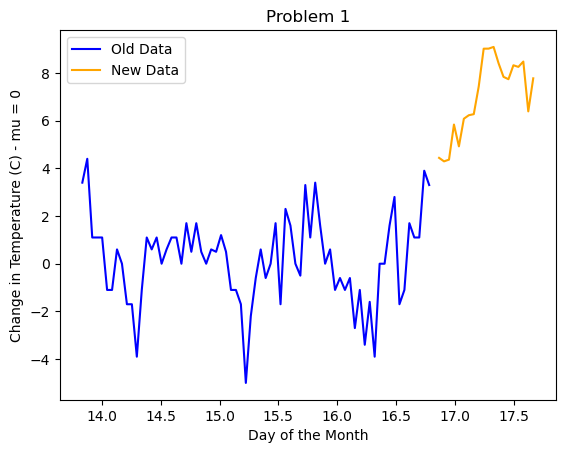

In [78]:
# Get weather data and the linspace
weather_data = arma_forecast_naive()
X_axis = (13 + 20/24) + np.linspace(0, 3 + 20/24, 92)

# Plot original data in blue
plt.plot(X_axis[:-21], weather_data[:-21], color='blue', label='Old Data')
# Plot forecasted data in orange
plt.plot(X_axis[-20:], weather_data[-20:], color='orange', label='New Data')

# Show the plot
plt.legend()
plt.xlabel('Day of the Month')
plt.ylabel('Change in Temperature (C) - mu = 0')
plt.title('Problem 1')
plt.show()

## Problem 2

In [79]:
def arma_likelihood(filename='weather.npy', phis=np.array([0.9]), thetas=np.array([0]), mu=17., std=0.4):
    """
    Transfer the ARMA model into state space.
    Return the log-likelihood of the ARMA model.

    Parameters:
        file (str): data file
        phis (ndarray): coefficients of autoregressive model
        thetas (ndarray): coefficients of moving average model
        mu (float): mean of errorm
        std (float): standard deviation of error

    Return:
        log_likelihood (float)
    """
    # The time series should be the change in temperature of weather.npy
    weather_data = np.diff((np.load(filename)))

    # Pull out F, Q, H using state_space_rep
    F,Q,H, _, _ = state_space_rep(phis, thetas, mu, std)
    
    # Get mus and covariances from Kalman Filter
    mus, covs = kalman(F,Q,H, weather_data - mu)
    
    # Initialize log_probabilities
    log_probability = 0
    
    # Add up all log probabilities
    for t in range(0,len(weather_data)):
        obs_pdf = norm.pdf(weather_data[t], H@ mus[t] + mu , np.sqrt(H @ covs[t] @ H.T))
        
        # Add the log probabilities
        log_probability += np.log(obs_pdf)
    
    # Return log probability
    return log_probability[0][0]
        
    

    

In [80]:
arma_likelihood()



-1375.1805469978774

In [81]:
from scipy.optimize import minimize

# Assume p, q, and time_series are defined
def f(x): # x contains the phis, thetas, mu, and std
    return -1 * arma_likelihood(filename = 'weather.npy', phis = x[:p], thetas = x[p:p+q])


## Problem 3

In [82]:
def model_identification(filename='weather.npy',p_max=4,q_max=4):
    """
    Identify parameters to minimize AIC of ARMA(p,q) model

    Parameters:
        file (str): data file
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model

    Returns:
        phis (ndarray (p,)): coefficients for AR(p)
        thetas (ndarray (q,)): coefficients for MA(q)
        mu (float): mean of error
        std (float): std of error
    """
    # The time series should be the change in temperature of weather.npy
    time_series = np.diff(np.load(filename))
    n = len(time_series)
    AIC_values = []
    sol_values = []
    
    # Load through all values of p and q
    for p in range(1,p_max + 1):
        for q in range(1, q_max +1):
            # Define f(x)
            def f(x):
                return -1 * arma_likelihood(filename, phis = x[:p], thetas = x[p:p+q], mu = x[-2], std = x[-1])
            
            # Create initial point
            x0 = np.zeros(p+q+2)
            x0[-2] = time_series.mean()
            x0[-1] = time_series.std()
            sol = minimize(f, x0, method = "SLSQP") 
            sol = sol['x']
            
            # Append the solution values
            sol_values.append(sol)
            
            # Get the AIC value
            k = p+q+2
            if p == q and q == 3:
                break
            l = -f(sol)
            aic = 2*k * (1 + (k+1)/(n-k)) - 2*l
            AIC_values.append(aic)
     
    # Return the solution      
    index = np.argmin(AIC_values)
    solution = sol_values[index]
    return solution[:1], solution[1:2], solution[-2], solution[-1]
            
            
            
               

In [83]:
phis, thetas, mu , std = model_identification()

/var/folders/td/8px6smg12fxf4nw_rf4snx840000gn/T/ipykernel_8096/3106484474.py:30: RuntimeWarning: invalid value encountered in sqrt
  obs_pdf = norm.pdf(weather_data[t], H@ mus[t] + mu , np.sqrt(H @ covs[t] @ H.T))
/var/folders/td/8px6smg12fxf4nw_rf4snx840000gn/T/ipykernel_8096/3106484474.py:33: RuntimeWarning: divide by zero encountered in log
  log_probability += np.log(obs_pdf)


## Problem 4

In [84]:
def arma_forecast(filename='weather.npy', phis=np.array([0]), thetas=np.array([0]), mu=0, std=0, n=30):
    """
    Forecast future observations of data.

    Parameters:
        file (str): data file
        phis (ndarray (p,)): coefficients of AR(p)
        thetas (ndarray (q,)): coefficients of MA(q)
        mu (float): mean of ARMA model
        std (float): standard deviation of ARMA model
        n (int): number of forecast observations
    """
    # Load in time series
    z = np.diff(np.load(filename))
    
    # Pull out F, Q, H using state_space_rep
    F,Q,H, _, _ = state_space_rep(phis, thetas, mu, std)
    
    # Use Kalman() to get mus and covs
    mus, covs = kalman(F,Q,H, z - mu)
    
    # Initialize the observation array
    obs_array = []
    
    # Update Step on the last elements
    y = z[-1] - mu - H @ mus[-1]
    S = H @ covs[-1] @ H.T
    K = covs[-1] @ H.T @ np.linalg.inv(S)
    mus_last = mus[-1] + K @ y
    covs_last  = (np.eye(len(K@H)) - K @ H) @ covs[-1]
    
    # Append the updated values to mus and covs
    mus = np.append(mus, [mus_last], axis = 0)
    covs = np.append(covs, [covs_last], axis = 0)
    
    # Now do a prediction steps n times    
    for i in range(n):
        mus_last = F @ mus[-1]
        covs_last = F @ covs[-1] @ F.T + Q
        
        # Get the mean and covariance of future observations
        obs_mean = H @ mus_last + mu
        obs_covariance = H @ covs_last @ H.T
        
        obs_array.append((obs_mean, obs_covariance))
        
        # Append the updated values to mus and covs
        mus = np.append(mus, [mus_last], axis = 0)
        covs = np.append(covs, [covs_last], axis = 0)
        
    return obs_array
        
        
    
    
    
    
    
    
    
    

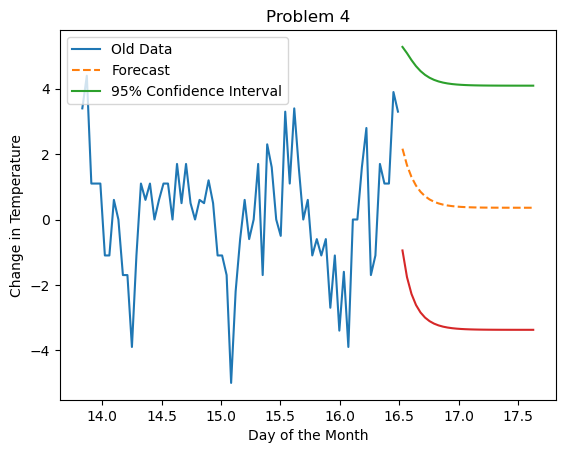

In [85]:
# Get the means and covariances
obs_array = arma_forecast(filename = 'weather.npy', phis = phis, thetas = thetas, mu = mu, std = std, n = 30)
extracted_values = np.array([[item[0][0], item[1][0,0]] for item in obs_array])

# Define the linspace
X_axis = (13 + 20/24) + np.linspace(0, 3 + 20/24, 102)

# Plot Data
plt.plot(X_axis[:-31],weather_data[:-21], label = 'Old Data')
plt.plot(X_axis[-31:-1],extracted_values[:,0], label = 'Forecast', linestyle = '--')
plt.plot(X_axis[-31:-1],extracted_values[:,0] + 2 * np.sqrt(extracted_values[:,1]), label = '95% Confidence Interval')
plt.plot(X_axis[-31:-1],extracted_values[:,0] - 2 * np.sqrt(extracted_values[:,1]))
plt.legend()
plt.title('Problem 4')
plt.xlabel('Day of the Month')
plt.ylabel('Change in Temperature')
plt.show()

## Problem 5

In [87]:
def sm_arma(filename='weather.npy', p_max=3, q_max=3, n=30):
    """
    Build an ARMA model with statsmodel and
    predict future n values.

    Parameters:
        filename (str): data filename
        p_max (int): maximum order of autoregressive model
        q_max (int): maximum order of moving average model
        n (int): number of values to predict

    Return:
        aic (float): aic of optimal model
    """
    
    # The time series should be the change in temperature of weather.npy
    time_series = np.diff(np.load(filename))
    aic_min = np.inf
    model_needed = None
    
    # Look through all possible values of and q 
    for p in range(1, p_max + 1):
        for q in range(1, q_max + 1):
            
            # Get the best model
            model = ARIMA(time_series, order = (p,0,q), trend = 'c').fit(method = 'innovations_mle')
            if (model.aic) < aic_min:
                aic_min = model.aic
                p_needed, q_needed = p,q
                model_needed = model
    
    # Get the means with that model
    means = model_needed.predict(start = 0, end = len(time_series) + 30)
    return aic_min, means, time_series
            
            

In [88]:
# Run Sm arma()
aic, means, weather_data = sm_arma()






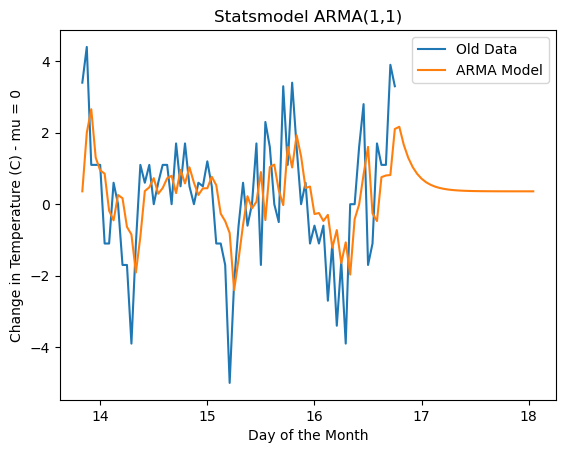

In [89]:
# Plot Prroblem 5
X_axis = (13 + 20/24) + np.linspace(0, (len(weather_data) + 30)/24, len(weather_data) + 31)
plt.plot(X_axis[:-31],weather_data, label = 'Old Data')
plt.plot(X_axis,means, label = 'ARMA Model')
plt.title('Statsmodel ARMA(1,1)')
plt.xlabel('Day of the Month')
plt.ylabel('Change in Temperature (C) - mu = 0')
plt.legend()
plt.show()


/Users/user/Local/Deep_Learning_Project/.conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


Text(0.5, 1.0, 'VARMA Predictions for World Copper Market Dataset')

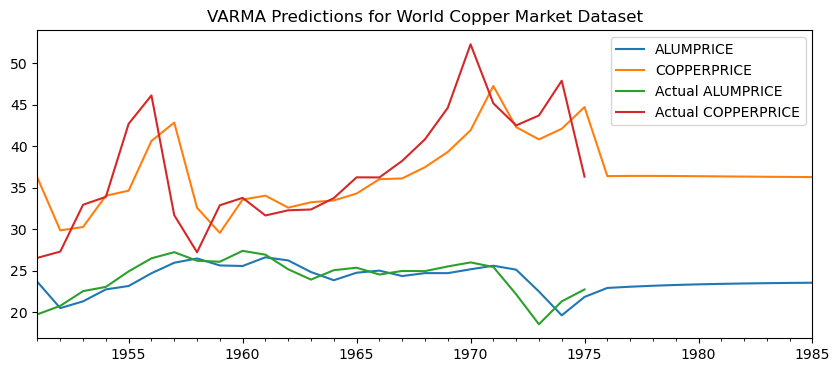

In [90]:
from statsmodels.tsa.api import VARMAX
import statsmodels.api as sm

# Load in world copper data
data = sm.datasets.copper.load_pandas().data
# Create index compatible with VARMAX model
data.index = pd.period_range(start = '1951', end = '1975', freq = 'Y')

# Initialize and fit model
mod = VARMAX(data[['ALUMPRICE', 'COPPERPRICE']])
mod = mod.fit(maxiter = 1000, disp = False)

# Predict the price of aluminium and copper until 1985
pred = mod.predict('1951', '1985')

# Get confidence intervals
forecast_obj = mod.get_forecast('1981')
all_CI = forecast_obj.conf_int(alpha = 0.05)

# Plot predictions against true price
pred.plot(figsize = (10,4))
plt.plot(data['ALUMPRICE'], label= 'Actual ALUMPRICE')
plt.plot(data['COPPERPRICE'], label = 'Actual COPPERPRICE')
plt.legend()
plt.title('VARMA Predictions for World Copper Market Dataset')


## Problem 6

In [91]:
# Load in data
df = sm.datasets.macrodata.load_pandas().data
# Create DatetimeIndex
dates = df[['year', 'quarter']].astype(int).astype(str)
dates = dates["year"] + "Q" + dates["quarter"]
dates = dates_from_str(dates)
df.index = pd.DatetimeIndex(dates)

# Select columns used in prediction
df = df[['realgdp', 'realcons', 'realinv']]


In [92]:
def sm_varma(start='1959-09-30', end='2012-09-30'):
    """
    Build an VARMAX model with statsmodel and
    forecast from start date until end date.

    Parameters:
        start (str): the data at which to begin forecasting
        end (str): the date at which to stop forecasting

    Return:
        aic (float): aic of optimal model
    """
    
    # Initialize and fit model
    mod = VARMAX(df, freq = 'Q-DEC')
    mod = mod.fit(maxiter = 1000, disp = False)
    
    # Predict from start to end
    pred = mod.predict(start = start, end = end)
    
    # Get confidence intervals
    forecast_obj = mod.get_forecast(end)
    all_CI = forecast_obj.conf_int(alpha = 0.05)
    
    # Plot Real GDP
    plt.plot(df['realgdp'], label = 'realgdp', color = 'blue')
    plt.plot(pred['realgdp'], label = 'forecast', color = 'orange')
    plt.plot(all_CI['lower realgdp'], 'k--', label = '95% Confidence Interval')
    plt.plot(all_CI['upper realgdp'], 'k--')
    plt.legend()
    plt.xlabel('year')
    plt.ylabel('realgdp')
    plt.title('realgdp prediction')
    plt.show()
    
    # Plot Real Cons
    plt.plot(df['realcons'], label = 'realcons', color = 'blue')
    plt.plot(pred['realcons'], label = 'forecast', color = 'orange')
    plt.plot(all_CI['lower realcons'], 'k--', label = '95% Confidence Interval')
    plt.plot(all_CI['upper realcons'], 'k--')
    plt.legend()
    plt.xlabel('year')
    plt.ylabel('realcons')
    plt.title('realcons prediction')
    plt.show()
    
    # Plot Real Inv
    plt.plot(df['realinv'], label = 'realgdp', color = 'blue')
    plt.plot(pred['realinv'], label = 'forecast', color = 'orange')
    plt.plot(all_CI['lower realinv'], 'k--', label = '95% Confidence Interval')
    plt.plot(all_CI['upper realinv'], 'k--')
    plt.legend()
    plt.xlabel('year')
    plt.ylabel('realinv')
    plt.title('realinv prediction')
    plt.show()
    
    
    
        

/Users/user/Local/Deep_Learning_Project/.conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/varmax.py:326: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  endog = np.require(endog.fillna(method='backfill'), requirements="W")


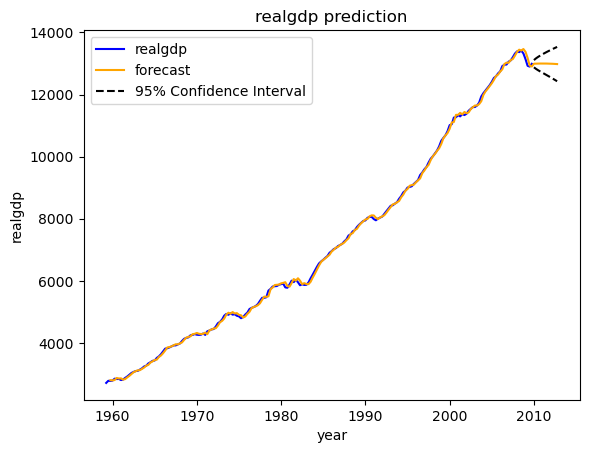

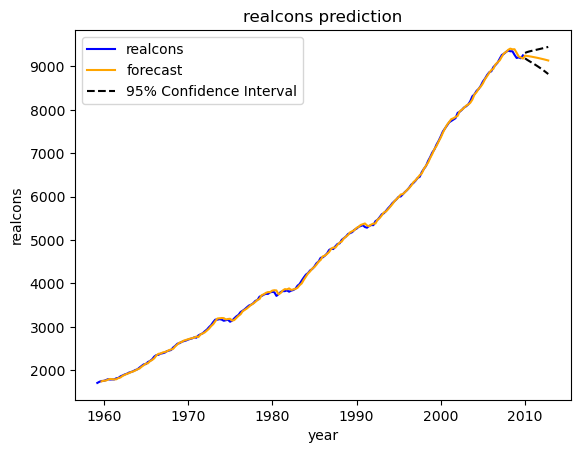

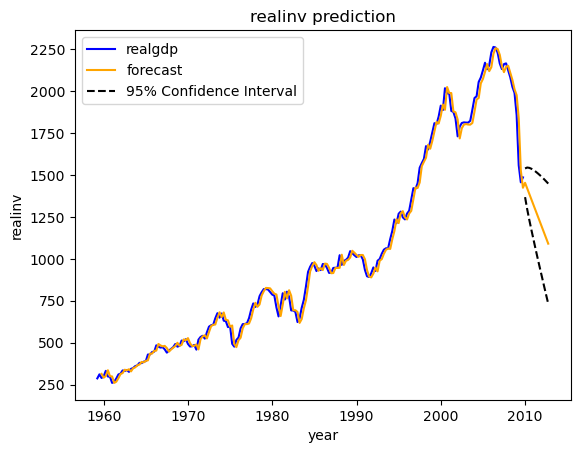

In [93]:
sm_varma()